## Importing libraries

In [375]:
#import cv2
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from PIL import Image as img
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import pickle, os, glob
from numpy import asarray
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
import time
import pickle

## Loading dataset 

In [10]:
styles_csv = pd.read_csv('styles_new.csv', error_bad_lines=False)

In [282]:
styles_csv.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN


In [39]:
articles_dict = {'Shirts': 0, 'Casual Shoes': 1, 'Watches': 2, 'Handbags': 3, 'Sunglasses': 4}
count_dict = {'Shirts': 0, 'Casual Shoes': 0, 'Watches': 0, 'Handbags': 0, 'Sunglasses': 0}
X_img, Y_label = [], []
for index, row in styles_csv.iterrows():
    if row['articleType'] in articles_dict.keys() and count_dict[row['articleType']] < 1000:
        count_dict[row['articleType']] += 1
        Y_label.append(articles_dict[row['articleType']])
        temp = load_img("./images/{}.jpg".format(row['id']), target_size=(80, 60, 3))
        temp = img_to_array(temp).flatten()
        temp = temp/255
        X_img.append(temp)
    if all(value == 1000 for value in count_dict.values()):
        break

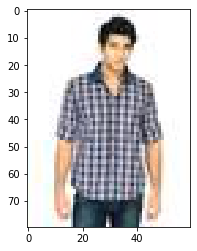

In [26]:
pyplot.imshow(np.uint8(X_img[0]*255).reshape(80, 60, 3))

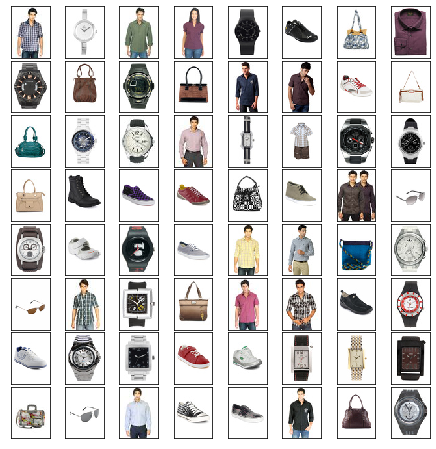

In [44]:
#Setup a figure 6 inches by 6 inches 
fig = pyplot.figure(figsize=(6,6)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

# plot products 
for i in range(64): 
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.uint8(X_img[i]*255).reshape(80, 60, 3), cmap=plt.cm.bone, interpolation='nearest') 
    
pyplot.show()

### Loading Entire Dataset

## PCA

In [76]:
pca = PCA().fit(X_img)

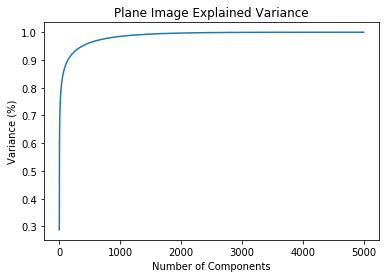

In [82]:
#Plotting the Cumulative Summation of the Explained Variance for Plane image
fig = pyplot.figure()
pyplot.plot(np.cumsum(pca.explained_variance_ratio_))
pyplot.xlabel('Number of Components')
pyplot.ylabel('Variance (%)') #for each component
pyplot.title('Plane Image Explained Variance')
pyplot.show()
fig.savefig('./figures/VariancePlot.jpg')

In [59]:
pca = PCA(n_components = 3600)
pca_img = pca.fit_transform(X_img)
print(np.sum(pca.explained_variance_ratio_))

0.9998692163978381


In [60]:
print(np.shape(pca_img))
# print(pca_img[0])

(5000, 3600)


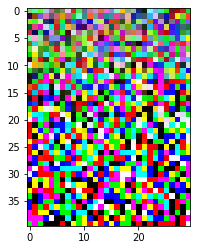

In [61]:
pyplot.imshow(np.uint8(pca_img[0]*255).reshape(40, 30, 3))

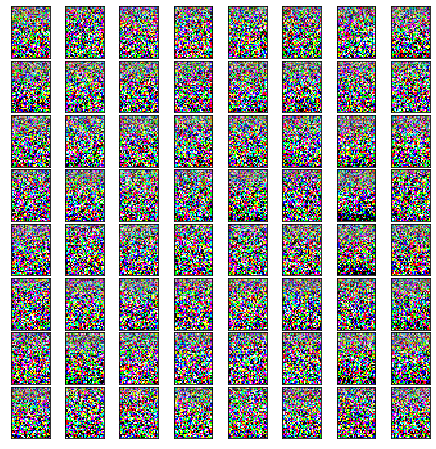

In [64]:
#Setup a figure 6 inches by 6 inches 
fig = pyplot.figure(figsize=(6,6)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

# plot the faces, each image is 64 by 64 pixels 
for i in range(64): 
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.uint8(pca_img[i]*255).reshape(40, 30, 3), cmap=plt.cm.bone, interpolation='nearest') 
    
pyplot.show()

### PCA - 2D

In [84]:
pca2D = PCA(n_components = 2)
pca2D_img = pca2D.fit_transform(X_img)
print(np.sum(pca2D.explained_variance_ratio_))

0.4525469529913744


In [85]:
print(np.shape(pca2D_img))
# print(pca_img[0])

(5000, 2)


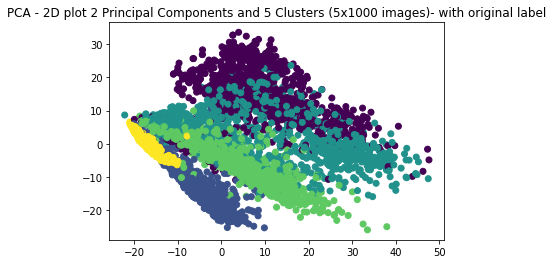

In [86]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(pca2D_img[:,0],pca2D_img[:,1], c=Y_label)
ax.set_title("PCA - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with original label")
pyplot.show()
fig.savefig('./figures/PCA2DPlot.jpg')

### PCA - 3D

In [87]:
pca3D = PCA(n_components = 3)
pca3D_img = pca3D.fit_transform(X_img)
print(np.sum(pca3D.explained_variance_ratio_))

0.546096745210249


In [88]:
print(np.shape(pca3D_img))
# print(pca_img[0])

(5000, 3)


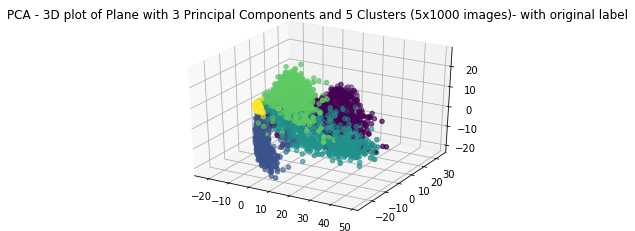

In [89]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3D_img[:,0],pca3D_img[:,1],pca3D_img[:,2], c=Y_label)
ax.set_title("PCA - 3D plot of Plane with 3 Principal Components and 5 Clusters (5x1000 images)- with original label")
pyplot.show()
fig.savefig('./figures/PCA3DPlot.jpg')

## t-SNE

### t-SNE - 2D

In [121]:
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=500)
tsne2D_results = tsne.fit_transform(X_img)

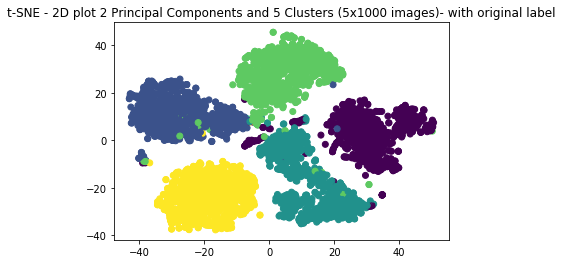

In [122]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(tsne2D_results[:,0],tsne2D_results[:,1], c=Y_label)
ax.set_title("t-SNE - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with original label")
pyplot.show()
fig.savefig('./figures/tSNE2DPlot.jpg')

### t-SNE - 3D

In [73]:
tsne = TSNE(n_components=3, verbose=0, perplexity=30, n_iter=500)
tsne3D_results = tsne.fit_transform(X_img)

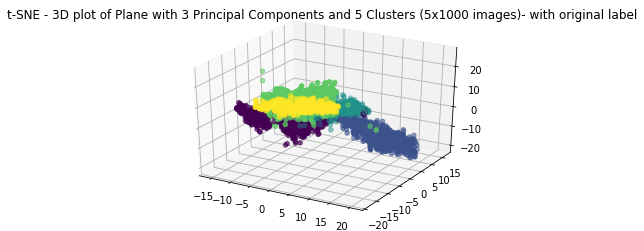

In [91]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3D_results[:,0],tsne3D_results[:,1],pca3D_img[:,2], c=Y_label)
ax.set_title("t-SNE - 3D plot of Plane with 3 Principal Components and 5 Clusters (5x1000 images)- with original label")
pyplot.show()
fig.savefig('./figures/tSNE3DPlot.jpg')

## K-Means Clustering

In [92]:
#Calculating elbow plot - 5D
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_img)
    sum_of_squared_distances.append(k_means.inertia_)

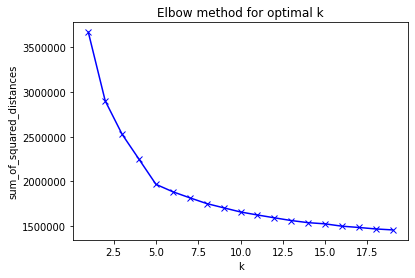

In [93]:
fig = pyplot.figure()
pyplot.plot(K, sum_of_squared_distances, 'bx-')
pyplot.xlabel('k')
pyplot.ylabel('sum_of_squared_distances')
pyplot.title('Elbow method for optimal k')
pyplot.show()
fig.savefig('./figures/KMeansElboPlot.jpg')

In [108]:
kmeans_cluster = KMeans(n_clusters=5, random_state=101, n_init=10, max_iter=500)
kmeans_cluster.fit(X_img)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels_km = kmeans_cluster.labels_

In [109]:
sc = metrics.silhouette_score(X_img, cluster_labels_km, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(X_img, cluster_labels_km)
print(sc)
print(ch)

0.23201138
1081.5831964099382


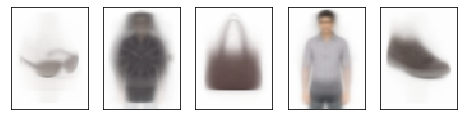

In [110]:
#Plotting cluster centers
fig, ax = pyplot.subplots(1, 5, figsize=(8, 3))
centers = cluster_centers.reshape(5, 80, 60, 3)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=pyplot.cm.binary)

In [112]:
print(cluster_labels_km)
print(np.array(Y_label))

[3 0 3 ... 0 0 0]
[0 2 0 ... 4 4 4]


In [115]:
preicted_km = []
for l in cluster_labels_km:
    if l == 0:
        preicted_km.append(4)
    elif l == 1:
        preicted_km.append(2)
    elif l == 2:
        preicted_km.append(3)
    elif l == 3:
        preicted_km.append(0)
    elif l == 4:
        preicted_km.append(1)
preicted_km = np.array(preicted_km)

In [116]:
print("Confusion Matrix: ")
print(confusion_matrix(Y_label, preicted_km))
print("Accuracy: ", metrics.accuracy_score(Y_label, preicted_km))

Confusion Matrix: 
[[ 779    7  153    2   59]
 [   1  770    0    1  228]
 [ 168   76  474    2  280]
 [   1    8   18  821  152]
 [   0    0    0    0 1000]]
Accuracy:  0.7688


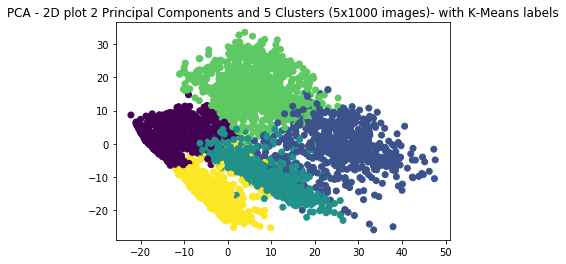

In [123]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(pca2D_img[:,0],pca2D_img[:,1], c=cluster_labels_km)
ax.set_title("PCA - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with K-Means labels")
pyplot.show()
fig.savefig('./figures/KMeansPCA2DPlot.jpg')

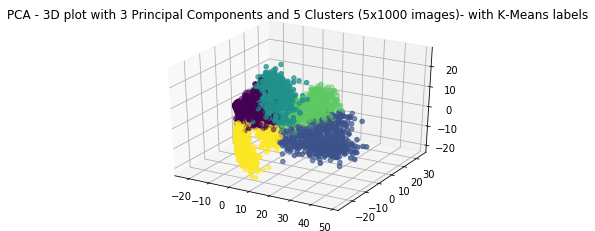

In [124]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3D_img[:,0],pca3D_img[:,1],pca3D_img[:,2], c=cluster_labels_km)
ax.set_title("PCA - 3D plot with 3 Principal Components and 5 Clusters (5x1000 images)- with K-Means labels")
pyplot.show()
fig.savefig('./figures/KMeansPCA3DPlot.jpg')

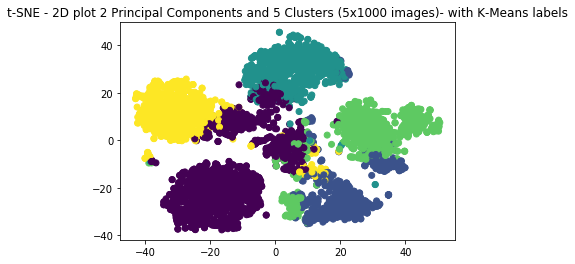

In [125]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(tsne2D_results[:,0],tsne2D_results[:,1], c=cluster_labels_km)
ax.set_title("t-SNE - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with K-Means labels")
pyplot.show()
fig.savefig('./figures/KMeanstSNE2DPlot.jpg')

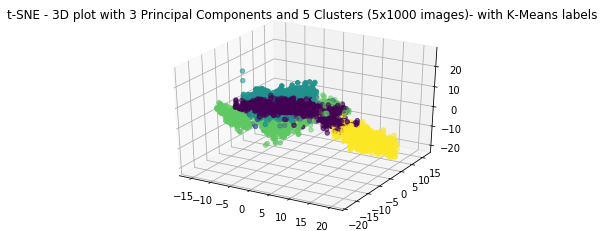

In [126]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3D_results[:,0],tsne3D_results[:,1],pca3D_img[:,2], c=cluster_labels_km)
ax.set_title("t-SNE - 3D plot with 3 Principal Components and 5 Clusters (5x1000 images)- with K-Means labels")
pyplot.show()
fig.savefig('./figures/KMeanstSNE3DPlot.jpg')

## Agglomerative Clustering

In [107]:
agg_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') 
agg_cluster.fit_predict(X_img)
cluster_labels_agg = agg_cluster.labels_

In [103]:
sc = metrics.silhouette_score(X_img, cluster_labels_agg, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(X_img, cluster_labels_agg)
print(sc)
print(ch)

0.20209014
935.4263675333775


In [104]:
print("Confusion Matrix: ")
print(confusion_matrix(Y_label, cluster_labels_agg))
print("Accuracy: ", metrics.accuracy_score(Y_label, cluster_labels_agg))

Confusion Matrix: 
[[  70  335    2    0  593]
 [ 272    0    2  725    1]
 [ 459  539    2    0    0]
 [  45    1  952    1    1]
 [1000    0    0    0    0]]
Accuracy:  0.0146


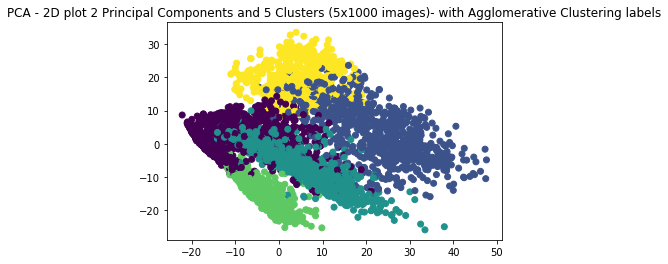

In [127]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(pca2D_img[:,0],pca2D_img[:,1], c=cluster_labels_agg)
ax.set_title("PCA - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with Agglomerative Clustering labels")
pyplot.show()
fig.savefig('./figures/AgglomerativePCA2DPlot.jpg')

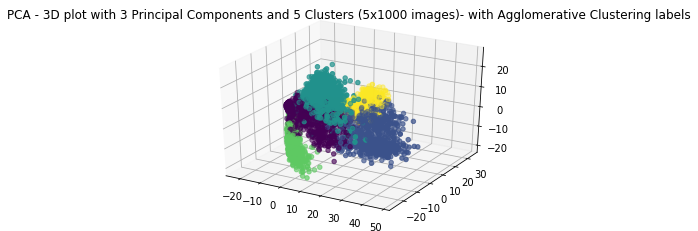

In [128]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3D_img[:,0],pca3D_img[:,1],pca3D_img[:,2], c=cluster_labels_agg)
ax.set_title("PCA - 3D plot with 3 Principal Components and 5 Clusters (5x1000 images)- with Agglomerative Clustering labels")
pyplot.show()
fig.savefig('./figures/AgglomerativePCA3DPlot.jpg')

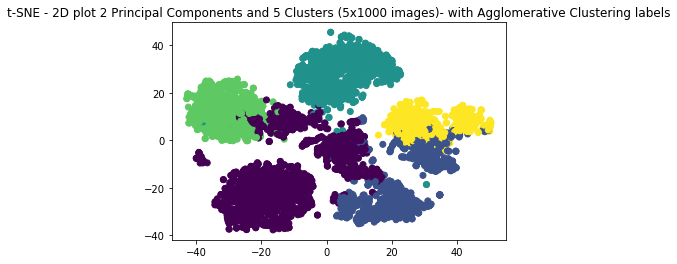

In [129]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(tsne2D_results[:,0],tsne2D_results[:,1], c=cluster_labels_agg)
ax.set_title("t-SNE - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with Agglomerative Clustering labels")
pyplot.show()
fig.savefig('./figures/AgglomerativetSNE2DPlot.jpg')

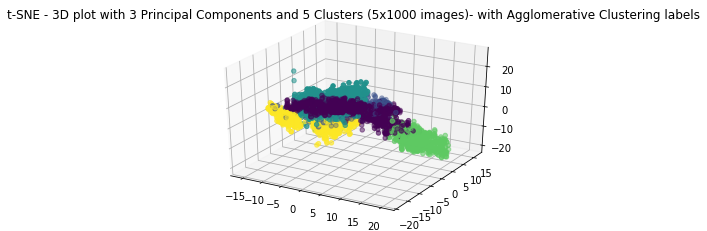

In [130]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3D_results[:,0],tsne3D_results[:,1],pca3D_img[:,2], c=cluster_labels_agg)
ax.set_title("t-SNE - 3D plot with 3 Principal Components and 5 Clusters (5x1000 images)- with Agglomerative Clustering labels")
pyplot.show()
fig.savefig('./figures/AgglomerativetSNE3DPlot.jpg')

## Gausian Mixture Model (GMM) Clustering

In [106]:
gmm_cluster = GaussianMixture(n_components=5)
gmm_cluster.fit(X_img)
cluster_labels_gmm = gmm_cluster.predict(X_img)

In [117]:
sc = metrics.silhouette_score(X_img, cluster_labels_gmm, metric = 'euclidean')
ch = metrics.calinski_harabasz_score(X_img, cluster_labels_gmm)
print(sc)
print(ch)

0.23202021
1081.5801704320313


In [118]:
print("Confusion Matrix: ")
print(confusion_matrix(Y_label, cluster_labels_gmm))
print("Accuracy: ", metrics.accuracy_score(Y_label, cluster_labels_gmm))

Confusion Matrix: 
[[  59    3  779    7  152]
 [ 228    1    1  770    0]
 [ 280    2  171   76  471]
 [ 152  820    1    9   18]
 [1000    0    0    0    0]]
Accuracy:  0.048


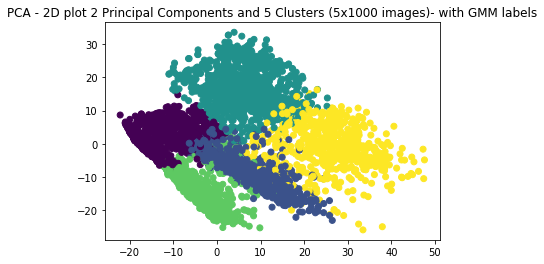

In [131]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(pca2D_img[:,0],pca2D_img[:,1], c=cluster_labels_gmm)
ax.set_title("PCA - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with GMM labels")
pyplot.show()
fig.savefig('./figures/GMMPCA2DPlot.jpg')

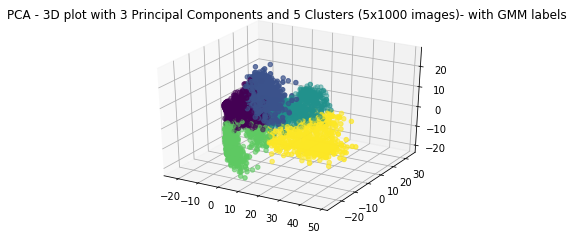

In [132]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3D_img[:,0],pca3D_img[:,1],pca3D_img[:,2], c=cluster_labels_gmm)
ax.set_title("PCA - 3D plot with 3 Principal Components and 5 Clusters (5x1000 images)- with GMM labels")
pyplot.show()
fig.savefig('./figures/GMMPCA3DPlot.jpg')

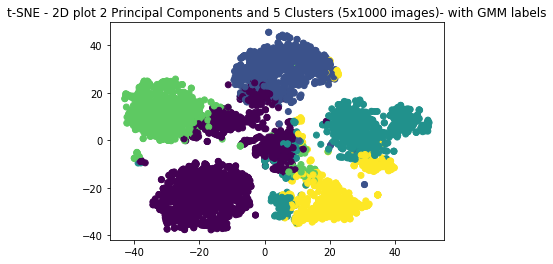

In [133]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(tsne2D_results[:,0],tsne2D_results[:,1], c=cluster_labels_gmm)
ax.set_title("t-SNE - 2D plot 2 Principal Components and 5 Clusters (5x1000 images)- with GMM labels")
pyplot.show()
fig.savefig('./figures/GMMtSNE2DPlot.jpg')

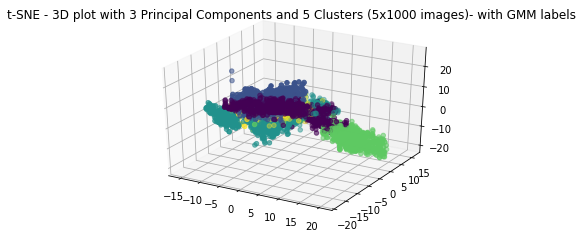

In [134]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3D_results[:,0],tsne3D_results[:,1],pca3D_img[:,2], c=cluster_labels_gmm)
ax.set_title("t-SNE - 3D plot with 3 Principal Components and 5 Clusters (5x1000 images)- with GMM labels")
pyplot.show()
fig.savefig('./figures/GMMtSNE3DPlot.jpg')

## Recommendations

In [2]:
#Test-Train split
X_img_train, X_img_test, y_label_train, y_label_test = train_test_split(X_img, Y_label, test_size=0.25, random_state=42)

NameError: name 'train_test_split' is not defined

### Cosine Similarity

In [1]:
X_img_train

NameError: name 'X_img_train' is not defined

In [361]:
def get_recommendation_cosine(img, top_n):
    temp = X_img_train.copy()
    temp.append(img)
    l = len(temp)
    cosine_sim = 1 - pairwise_distances(temp, metric='cosine')
    sim_scores = list(enumerate(cosine_sim[l-1]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    return idx_rec, idx_sim

In [362]:
def display_recommendation_cosine(ref_img, top_n):
    
    #Getting recommendations
    idx_rec, idx_sim = get_recommendation_cosine(ref_img, top_n)
    rec_images = []
    for r in idx_rec:
        rec_images.append(X_img_train[r])
    rec_images = np.array(rec_images)
    
    #plotting original image
    pyplot.imshow(np.uint8(ref_img*255).reshape(80, 60, 3))
    pyplot.title("Original Image")
    pyplot.show()
    
    #Plotting recommendations
    fig, ax = pyplot.subplots(1, top_n, figsize=(8, 3))
    rec = rec_images.reshape(top_n, 80, 60, 3)
    for axi, center in zip(ax.flat, rec):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=pyplot.cm.binary)
        

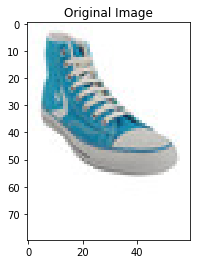

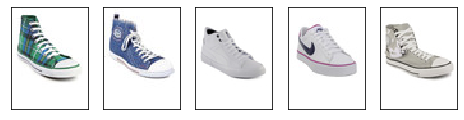

In [377]:
display_recommendation_cosine(X_img_test[4], 5)

### Distance Matrix

In [385]:
def reduced_images(img):
    temp = X_img_train.copy()
    temp.append(img)
    pca = PCA(n_components = 500)
    pca_rec = pca.fit_transform(temp)
    return pca_rec

In [386]:
def get_recommendation_spatial_dist(img, top_n):
    temp = reduced_images(img)
    l = len(temp)
    dist_sim = distance_matrix(temp, temp)
    dist_scores = list(enumerate(dist_sim[l-1]))
    dist_scores = sorted(dist_scores, key=lambda x: x[1], reverse=False)
    dist_scores = dist_scores[1:top_n+1]
    idx_rec    = [i[0] for i in dist_scores]
    idx_sim    = [i[1] for i in dist_scores]
    return idx_rec, idx_sim

In [387]:
def display_recommendation_spatial_dist(ref_img, top_n):
    
    #Getting recommendations
    idx_rec, idx_sim = get_recommendation_spatial_dist(ref_img, top_n)
    rec_images = []
    for r in idx_rec:
        rec_images.append(X_img_train[r])
    rec_images = np.array(rec_images)
    
    #plotting original image
    pyplot.imshow(np.uint8(ref_img*255).reshape(80, 60, 3))
    pyplot.title("Original Image")
    pyplot.show()
    
    #Plotting recommendations
    fig, ax = pyplot.subplots(1, top_n, figsize=(8, 3))
    rec = rec_images.reshape(top_n, 80, 60, 3)
    for axi, center in zip(ax.flat, rec):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=pyplot.cm.binary)
        

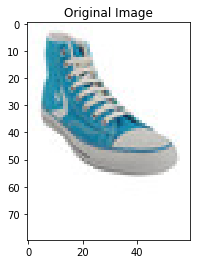

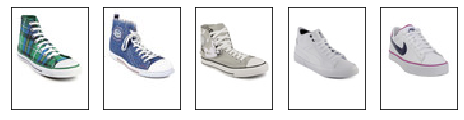

In [390]:
display_recommendation_spatial_dist(X_img_test[4], 5)